Vamos a ver cómo poder ver un vídeo en el notebook sin necesidad de crear una copia en disco del mismo. En realidad es una excusa para, en el camino, hablar de *web map services* ([WMS](https://es.wikipedia.org/wiki/Web_Map_Service)), de imágenes satelitales, sistemas de coordenadas [CRS](https://docs.qgis.org/2.18/en/docs/gentle_gis_introduction/coordinate_reference_systems.html), [Cartopy](http://scitools.org.uk/cartopy/), [Matplotlib](https://matplotlib.org/), meteorología, predicción, [servidores de datos THREDDS](https://www.unidata.ucar.edu/software/thredds/current/tds/reference/index.html),... Como todo lo anterior no cabe en un título lo dejaremos como 'Creación de vídeos al vuelo en el notebook'.

Antes de nada, vamos a necesitar las siguientes bibliotecas, además de cosas de la *stdlib*:

* Numpy (para manejar datos)
* Matplotlib (para pintar en gráficos)
* Cartopy (para pintar en mapas)
* IPython + Jupyter notebook (para representar los datos en el notebook)
* owslib (para acceder a Web Map Services)
* XArray (para manejar ficheros NetCDF de forma sencilla)
* NetCDF4 (driver para leer y escribir ficheros NetCDF)
* Siphon (para acceder a datos en servidores THREDDS)
* ffmpeg (para utilizar como respaldo de Matplotlib en la generación del vídeo).

Todo lo anterior es fácilmente instalable vía `conda` usando el canal de `conda-forge` tanto en Linux como en Windows. Los siguientes comandos en una consola o en el Anaconda Prompt (Windows) harán el trabajo:

    conda create -n videos_env numpy matplotlib cartopy notebook owslib xarray netcdf4 siphon ffmpeg -c conda-forge

Luego activamos el entorno virtual. Elige una sola de las líneas de debajo, la que corresponda con tu conda y sistema operativo:

    conda activate videos_env # para conda moderno
    source activate videos_env # en conda antiguo y linux
    activate videos_env # en conda antiguo y windows
  
Y, por último, dentro de nuestra terminal nos vamos a la carpeta en la que se encuentre este notebook y arrancamos el notebook:

    jupyter notebook

Como siempre, vamos a importar todo lo necesario:

In [1]:
import datetime as dt
from io import BytesIO
from pathlib import Path
from glob import glob
from urllib.request import urlretrieve
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation
from matplotlib.image import imread
import cartopy.crs as ccrs
from IPython.display import HTML
from owslib.wms import WebMapService
import xarray as xr
import netCDF4 as nc
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

%matplotlib inline

# WMS

Un [servicio de mapas web](https://es.wikipedia.org/wiki/Web_Map_Service) es un estándar definido por el [Open Geospatial Consortium](http://www.opengeospatial.org/) que ofrece, grosso modo, poder hacer determinadas peticiones al servicio y este nos devolverá información geográfica que podremos representar en un mapa.

Existen otra [serie de servicios complementarios](https://gis.stackexchange.com/questions/80948/what-are-the-differences-between-wms-wfs-wcs-wps/80950#80950) en los que no vamos a entrar puesto que lo que vamos a hacer hoy es bastante simple.

¿Para qué vamos a usar un WMS? Primero de todo, vamos a descargarnos imágenes de satélite del [MSG](http://www.esa.int/Our_Activities/Observing_the_Earth/Meteosat_Second_Generation). En este caso del MSG que está colocado a 0º de longitud actualmente. Si no ando muy equivocado este es el Meteosat 10 o Meteosat Second Generation 3 (el décimo de todos los Meteosat o el tercero de los Meteosat de segunda generación).

**[Curiosidad, hace unos meses se cumplieron 40 años desde el lanzamiento del Meteosat 1]**.

Para el que no lo sepa, el MSG3 es un satélite de [órbita geoestacionaria](https://es.wikipedia.org/wiki/%C3%93rbita_geoestacionaria). Esto quiere decir que orbita desde el plano que define el ecuador terrestre mirando siempre al mismo punto de la tierra.

Bueno, al lío, vamos a descargar imágenes del MSG3 del canal infrarrojo 10.8 ${\mu}m$.

[Breve inciso: ese canal nos permite diferenciar características térmicas y así ver diferencias entre cuerpos más calientes o más fríos como la superficie terrestre o la parte alta de las nubes].

Accedemos a un WMS de EUMETSAT.

In [2]:
# accedemos a un WMS de eutmetsat:
wms = WebMapService("https://eumetview.eumetsat.int/geoserv/wms", version="1.3.0")
print(wms.identification.title)
print(wms.identification.type)
print(wms.identification.abstract)

EUMETSAT
WMS
EUMETSAT visualizations offering via WMS


Vemos los contenidos del WMS y destacamos del resto la capa que usaremos. También guardamos el nombre de la capa de interés en la variable `layer`.

In [3]:
# Vemos los contenidos del WMS y destacamos la capa que usaremos
# También guardamos el nombre de la capa de interés en la 
# variable 'layer'
layer = "meteosat:msg_ir108"
for key in wms.contents.keys():
    if key == layer:
        print("\t" * 3, "------->", key)
    else:
        print(key)

bkg-raster:bkg-raster
meteosat:msg_airmass
meteosat:msg_airmass_3995
meteosat:msg_ash
meteosat:msg_ash_3995
meteosat:msg_clai
meteosat:msg_clai_3995
meteosat:msg_clm
meteosat:msg_clm_3995
meteosat:msg_convection
meteosat:msg_convection_3995
meteosat:msg_cth
meteosat:msg_cth_3995
meteosat:msg_dust
meteosat:msg_dust_3995
meteosat:msg_eview
meteosat:msg_eview_3995
meteosat:msg_fire
meteosat:msg_fire_3995
meteosat:msg_fog
meteosat:msg_fog_3995
meteosat:msg_ir039
meteosat:msg_ir039_3995
			 -------> meteosat:msg_ir108
meteosat:msg_ir108_3995
meteosat:msg_microphysics
meteosat:msg_microphysics_3995
meteosat:msg_mpe
meteosat:msg_mpe_3995
meteosat:msg_natural
meteosat:msg_natural_3995
meteosat:msg_snow
meteosat:msg_snow_3995
meteosat:msg_vis006
meteosat:msg_vis006_3995
meteosat:msg_wv062
meteosat:msg_wv062_3995
msgiodc:msgiodc_airmass
msgiodc:msgiodc_airmass_3995
msgiodc:msgiodc_ash
msgiodc:msgiodc_ash_3995
msgiodc:msgiodc_clai
msgiodc:msgiodc_clai_3995
msgiodc:msgiodc_clm
msgiodc:msgiodc_clm_

Veamos las coordenadas disponibles para nuestra capa de interés:

In [4]:
# Veamos las coordenadas disponibles para nuestra capa de interés:
wms[layer].boundingBox

(-77.0, -77.0, 77.0, 77.0, 'CRS:84')

Y los estilos disponibles para la capa:

In [5]:
# Los estilos disponibles:
wms[layer].styles

{'raster': {'legend': 'https://eumetview.eumetsat.int/geoserver/ows?service=WMS&request=GetLegendGraphic&format=image%2Fpng&width=20&height=20&layer=meteosat%3Amsg_ir108',
  'legend_format': 'image/png',
  'legend_height': '20',
  'legend_width': '20',
  'title': 'A boring default style'}}

Y los posibles sistemas de coordenadas a usar:

In [6]:
# Los posibles sistemas de coordenadas:
wms[layer].crsOptions

['CRS:84', 'EPSG:3857', 'EPSG:3995', 'EPSG:4326']

[Breve inciso: resumidísimo y sin entrar en mucho detalle, estamos analizando objetos tridimensionales que queremos representar en un espacio bidimensional como la pantalla de nuestro PC, teléfono, en un papel,... Necesitamos poder transformar posiciones de un espacio a otro. Para ello se han inventado los [sistemas de referencia espaciales](https://en.wikipedia.org/wiki/Spatial_reference_system) que nos permiten hacer esas transformaciones. Estas [transformaciones son imperfectas ya que hemos de sacrificar algunas de las características (ángulo, área, distancia) del original ya que solo podemos mantener alguna de ellas sin distorsiones](http://geoawesomeness.com/top-7-maps-ultimately-explain-map-projections/)].

Vamos a usar [WGS84, EPSG 4326 o Plate Carree un poco de forma indistinta aunque **NO** son lo mismo pero la extensión que tenemos no permite entrar en muchos detalles](https://gis.stackexchange.com/questions/21352/how-is-epsg4326-data-projected-in-a-2d-map/21372#21372). Esto es lo que se suele usar para los mapas de [OpenStreetMap](https://osm.org).

Bueno, centrémonos, vamos a descargar las imágenes del canal IR 10.8 cada 6 horas desde hace 5 días hasta hoy usando un WMS de Eumetsat:

Definimos las fechas para las que descargaremos información:

In [7]:
# Primero las fechas que usaremos (en UTC)
utcnow = dt.datetime.now(dt.timezone.utc)
five_days_ago = utcnow.date() - dt.timedelta(days=5)
datetime = dt.datetime(five_days_ago.year, 
                       five_days_ago.month, 
                       five_days_ago.day, 
                       0,
                       tzinfo=dt.timezone.utc)
datetimes = [datetime]
while datetimes[-1] < utcnow:
    datetimes.append(datetimes[-1] + dt.timedelta(hours=6))

Le decimos al WMS cómo queremos las cosas (qué capa, en qué área,...):

In [8]:
# Ahora creamos el diccionario para el WMS
# con todos nuestros requerimientos
wms_params = {
    "bbox": (-40, 20, 40, 70),
    "size": (800, 500),
    "srs": "EPSG:4326",
    "layers": ["meteosat:msg_ir108"],
    "format": "image/jpeg"
}

Hacemos la petición al WMS para cada fecha con nuestros requerimientos:

In [9]:
# Pedimos las imágenes al WMS añadiendo la fecha
# en cada petición:
imgs = []
for datetime in datetimes:
    wms_params["time"] = datetime.isoformat().replace("+00:00", "Z") # ugly hack
    imgs.append(wms.getmap(**wms_params))

Obviamente, dependiendo del momento en que ejecutes el notebook o lo leas en nuestro blog las fechas no tienen porqué ser las mismas ni estar actualizadas...

In [10]:
# Depende de la hora a la que ejecutes esto tendrás
# fechas distintas, imágenes distintas, cantidad
# de imágenes distinta
len(imgs)

23

Ahora mismo ya podríamos crear un vídeo, pero de momento solo vamos a usar matplotlib para visualizar las tres primeras imágenes:

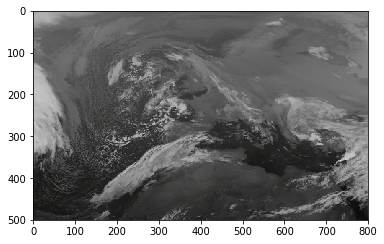

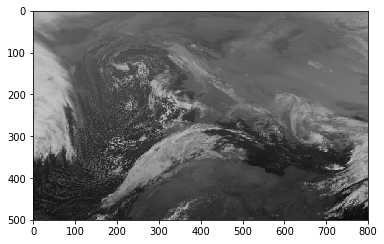

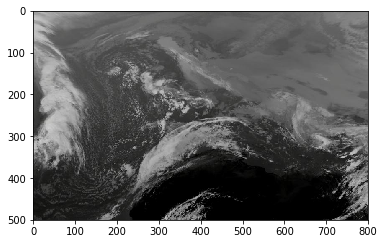

In [11]:
for img in imgs[:3]:
    imgfile = BytesIO()
    imgfile.write(img.read())
    imgfile.seek(0)
    data = imread(imgfile, format="jpeg")
    fig, ax = plt.subplots()
    ax.imshow(data)

# Meteorología y predicción

Ahora vamos a usar los datos de un modelo global de predicción atmosférica. El modelo en cuestión es el [GFS (Global Forecast System) y lo gestiona el National Center for Environmental Prediction (NCEP)](http://www.emc.ncep.noaa.gov/index.php?branch=GFS). Estos son los modelos que nos dicen si lloverá mañana y son muy sofisticados pero también hacen muchas concesiones para poder correrlos en un supercomputador en tiempo y forma. No voy a entrar mucho más en ello, si alguien tiene alguna pregunta concreta que se dirija a [@Dr_Meteo, mi alter ego tuitero](https://twitter.com/Dr_Meteo) o use los comentarios en el blog.

[INCISO: esa cuenta de twitter está en modo mantenimiento por eso de la vigilancia masiva, si no contesto usad @pybonacci].

Bien, vamos a descargar datos del GFS cuya ejecución empezase en el momento de la primera imagen disponible del Meteosat (hace cinco días) y ver cómo el modelo ha predicho la nubosidad y precipitación hasta hoy viendo conjuntamente la imagen del Meteosat y los campos del modelo.

El modelo produce [muchísimas variables](http://www.nco.ncep.noaa.gov/pmb/products/gfs/gfs.t00z.pgrb2.0p25.f006.shtml), todas ellas interesantísimas, en muchos niveles verticales y para un horizonte de predicción de hasta 384 horas. Como he comentado anteriormente me voy a centrar en estas cuatro:

|Number |Level/Layer |Parameter |Forecast Valid |Description|
|:---:|:---:|:---:|:---:|:---:|
|292 |surface |APCP |0-6 hour acc |Total Precipitation [kg/m^2]|
|317 |low cloud layer |TCDC |0-6 hour ave |Total Cloud Cover [%]|
|318 |middle cloud layer |TCDC |0-6 hour ave |Total Cloud Cover [%]|
|319 |high cloud layer |TCDC |0-6 hour ave |Total Cloud Cover [%]|
|320 |entire atmosphere |TCDC |0-6 hour ave |Total Cloud Cover [%]|

Las variables anteriores son un promedio en un periodo de 6 horas por lo que no es exactamente lo mismo que nos ofrece una imagen de satélite, que es un instante, pero para lo que queremos hacer nos vale.

Vamos a descargar lo que necesitamos de un servidor THREDDS, que es un tipo de servidor que ofrece la posibilidad de descargar datos geofísicos siguiendo una serie de estándares, siguiendo la misma filosofía a lo que hemos visto con WMS.

Generamos la URL para el día en que comenzará la predicción, que será el mismo momento en que empiezan las imágenes del Meteosat:

In [12]:
# generamos la URL para el día en que comenzará la predicción,
# que será el mismo momento en que empiezan las imágenes
# del Meteosat:
url = ("https://nomads.ncdc.noaa.gov/thredds/catalog/gfs-004/"
       f"{five_days_ago.strftime('%Y%m')}/"
       f"{five_days_ago.strftime('%Y%m%d')}/catalog.xml")

Creamos una instancia de un objeto que nos permitirá descargar los datos del servidor THREDDS.

In [13]:
thredds = TDSCatalog(url)

Veamos todos los datos disponibles:

In [14]:
# Los datos disponibles se pueden ver así:
print(thredds.datasets)

['GFS Grid 4  2018-11-22 18:00 UTC fct:384.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:372.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:360.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:348.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:336.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:324.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:312.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:300.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:288.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:276.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:264.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:252.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:240.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:237.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:234.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:231.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:228.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:225.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:222.grb2', 'GFS Grid 4  2018-11-22 18:00 UTC fct:219.grb2', 'GFS Grid 4  2018-1

Ahora vamos a usar un servicio especial de THREDDS que nos permite descargar solo un subconjunto de datos y además nos permite hacerlo en formato netCDF, que es más amigable para los que estén en Windows. El servicio en cuestión se llama NetCDFSubset (NCS). Como solo voy a descargar los datos en común con las imágenes de Meteosat voy, además, a seleccionar solo un subconjunto de todos los ficheros de GFS disponibles en THREDDS:

In [15]:
# guardamos los desfases desde el inicio en horas
desfases = []
for d in datetimes:
    desfase = (d - datetimes[0]).total_seconds()
    desfases.append(int(desfase / 3600))

Generamos las url's para cada momento de la predicción del modelo.

In [16]:
# Las urls para los ficheros que necesitamos las sacaremos 
# de la siguiente forma:
ncss_urls = []
for ds in thredds.datasets.values():
    name = ds.name
    ds_desfase = int(name.split('fct:')[1].split('.')[0])
    if ds_desfase in desfases and "00:00" in name:
        ncss_urls.append(ds.access_urls["NetcdfServer"])    

In [17]:
ncss_urls

['https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_132.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_126.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_120.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_114.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_108.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_102.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_096.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_090.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_084.grb2',
 'https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/

Empezamos a pedir los datos del modelo y los guardamos en memoria. Los datos a las 00.00 del primer dia no existen puesto que no puede haber un promedio en las 6 horas antes a empezar. Por tanto, esos datos del primer momento no se descargan.

AVISO: Esto puede tardar un rato, es mucha información y está metido en un while que seguirá intentando descargarlo todo hasta que no queden ficheros para descargar. Si, por la razón que sea, veis que tarda demasiado y los ficheros que está intentando descargar se repiten mucho cortadlo porque algo está pasando (el servidor está caído, está en mantenimiento,...).

In [18]:
# Empezamos a pedir los datos y los guardamos en memoria
# Los datos a las 00.00 del primer dia no existen puesto
# que no puede haber un promedio en las 6 horas antes a empezar
# Por tanto esos datos del primer momento no se descargan
ncs = []
#path = Path('.', 'netcdfs')
#path.mkdir(exist_ok=True)
i = 0
while len(ncss_urls) > 1:
    sleep(i)
    for url in ncss_urls:
        try:
            if "000.grb2" in url:
                continue
            print(url)
            ncss = NCSS(url)
            query = ncss.query()
            query.lonlat_box(north=70, south=20, east=359.5, west=0)
            query.accept('netcdf4')
            query.add_lonlat()
            query.var = set()
            query.variables("Total_cloud_cover_entire_atmosphere",
                            "Total_cloud_cover_high_cloud",
                            "Total_cloud_cover_middle_cloud",
                            "Total_cloud_cover_low_cloud",
                            "Total_precipitation")
            ncobj = ncss.get_data(query)
            ncs.append(ncobj)
            ncss_urls.remove(url)
            kkkkkkkkkk
        except:
            continue
        i += 1

https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_132.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_120.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_108.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_096.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_084.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_072.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_066.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_060.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_048.grb2
https://nomads.ncdc.noaa.gov/thredds/ncss/grid/gfs-004/201811/20181122/gfs_4_20181122_0000_036.grb2


In [19]:
# ordenamos los objetos NetCDF por fechas.
ncs_ordenado = [None] * (len(ncs) + 1)
for ncobj in ncs:
    desfase = ncobj.variables['time1'][:][0]
    posicion = desfases.index(desfase)
    ncs_ordenado[posicion] = ncobj

Ya hemos descargado los ficheros y los tenemos en objetos NetCDF en memoria. Vamos a usar `xarray` para ver el primero (el de las 06:00 UTC desde la hora de inicio).

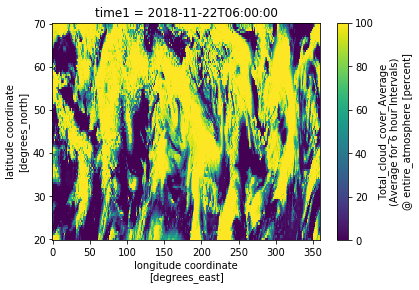

In [20]:
xarr = xr.open_dataset(xr.backends.NetCDF4DataStore(ncs_ordenado[1]))
xarr.Total_cloud_cover_entire_atmosphere.plot()

# Cartopy

Vamos a usar cartopy para crear cada frame ya que nos permite trabajar de forma simple con mapas.

Un ejemplo de cómo crear un frame:

Text(0.5,1,'GFS entire atmosphere (%)')

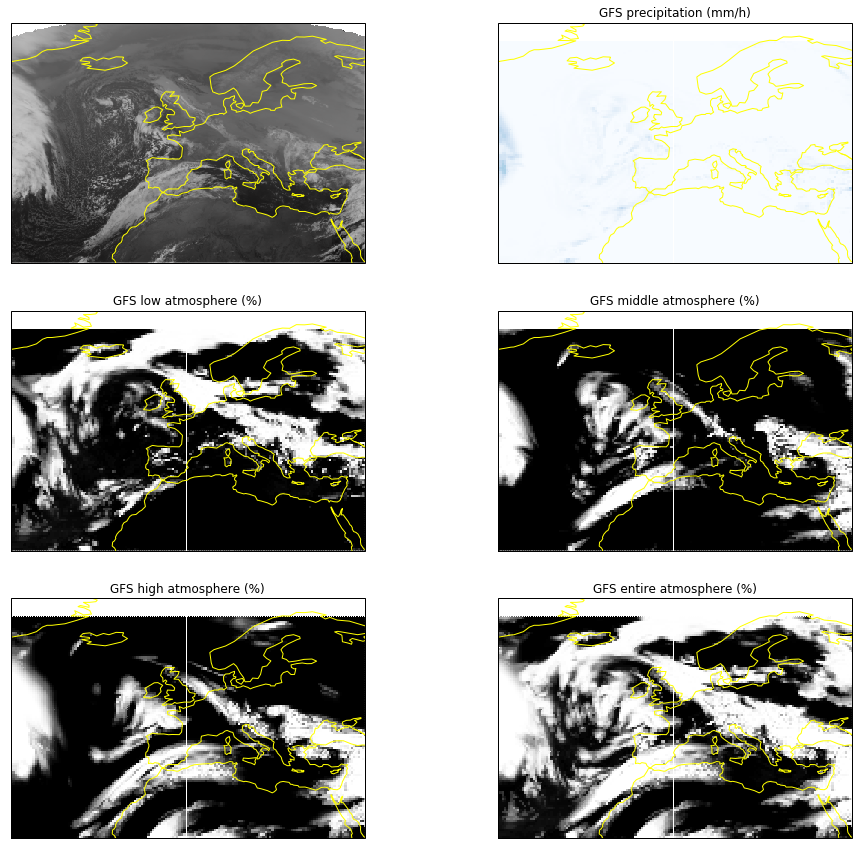

In [21]:
fig, axs = plt.subplots(nrows=3,
                               ncols=2,
                               figsize=(16, 15),
                               subplot_kw={'projection': ccrs.PlateCarree()})
for ax in axs.flatten():
    ax.coastlines(color='yellow')
# Ahora creamos el diccionario para el WMS
# con todos nuestros requerimientos para
# descargar la imagen de meteosat
wms_params = {
    "time": datetimes[1].isoformat().replace("+00:00", "Z")
}
axs[0,0].add_wms(wms, layers=["meteosat:msg_ir108"], wms_kwargs=wms_params)
for ax in axs.flatten():
    ax.set_extent((-40, 40, 20, 70))
cld_low = xarr.Total_cloud_cover_low_cloud[0,:,:]
cld_mid = xarr.Total_cloud_cover_middle_cloud[0,:,:]
cld_hig = xarr.Total_cloud_cover_high_cloud[0,:,:]
cld_ent = xarr.Total_cloud_cover_entire_atmosphere[0,:,:]
precip = xarr.Total_precipitation[0,:,:]
lon = xarr.lon
lat = xarr.lat
axs[0,1].pcolormesh(lon, lat, precip, cmap=cm.Blues)
axs[0,1].set_title("GFS precipitation (mm/h)")
axs[1,0].pcolormesh(lon, lat, cld_low, cmap=cm.Greys_r)
axs[1,0].set_title("GFS low atmosphere (%)")
axs[1,1].pcolormesh(lon, lat, cld_mid, cmap=cm.Greys_r)
axs[1,1].set_title("GFS middle atmosphere (%)")
axs[2,0].pcolormesh(lon, lat, cld_hig, cmap=cm.Greys_r)
axs[2,0].set_title("GFS high atmosphere (%)")
axs[2,1].pcolormesh(lon, lat, cld_ent, cmap=cm.Greys_r)
axs[2,1].set_title("GFS entire atmosphere (%)")

En los mapas con datos del modelo veis una raya en longitud 0º. Es debido a que los datos terminan antes de longitud 360º. Esto es fácilmente corregible pero os lo dejo como ejercicio.

# Vídeo

Ya tenemos todos los ingredientes para crear el vídeo que queríamos hacer y poder visualizar directamente en el notebook. Tendremos que crear primero los frames que vamos a usar en el vídeo y después crear la animación.

Para lo primero podemos hacer:

Generando frame para 2018-11-22 00:00:00+00:00
Generando frame para 2018-11-22 06:00:00+00:00
Generando frame para 2018-11-22 12:00:00+00:00
Generando frame para 2018-11-22 18:00:00+00:00
Generando frame para 2018-11-23 00:00:00+00:00
Generando frame para 2018-11-23 06:00:00+00:00
Generando frame para 2018-11-23 12:00:00+00:00
Generando frame para 2018-11-23 18:00:00+00:00
Generando frame para 2018-11-24 00:00:00+00:00
Generando frame para 2018-11-24 06:00:00+00:00
Generando frame para 2018-11-24 12:00:00+00:00
Generando frame para 2018-11-24 18:00:00+00:00
Generando frame para 2018-11-25 00:00:00+00:00
Generando frame para 2018-11-25 06:00:00+00:00
Generando frame para 2018-11-25 12:00:00+00:00
Generando frame para 2018-11-25 18:00:00+00:00
Generando frame para 2018-11-26 00:00:00+00:00
Generando frame para 2018-11-26 06:00:00+00:00
Generando frame para 2018-11-26 12:00:00+00:00
Generando frame para 2018-11-26 18:00:00+00:00
Generando frame para 2018-11-27 00:00:00+00:00
Generando fra

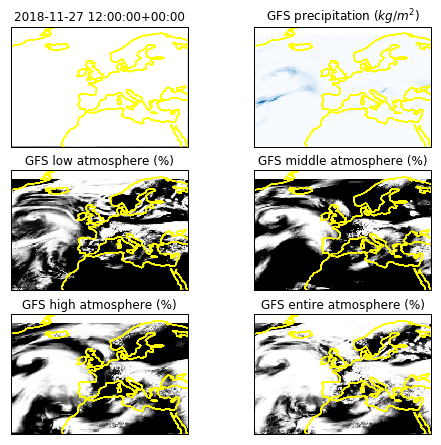

In [22]:
frames = []
fig, axs = plt.subplots(nrows=3,
                               ncols=2,
                               figsize=(8, 7.5),
                               subplot_kw={'projection': ccrs.PlateCarree()})
for i, (img, ncobj) in enumerate(zip(imgs, ncs_ordenado)):
    print(f"Generando frame para {datetimes[i]}")
    for ax in axs.flatten():
        ax.coastlines(color='yellow')
    # Ahora creamos el diccionario para el WMS
    # con todos nuestros requerimientos para
    # descargar la imagen de meteosat
    wms_params = {
        "time": datetimes[i].isoformat().replace("+00:00", "Z")
    }
    ax00 = axs[0,0].add_wms(wms, layers=["meteosat:msg_ir108"], wms_kwargs=wms_params)
    t = axs[0,0].set_title(datetimes[i])
    for ax in axs.flatten():
        ax.set_extent((-40, 40, 20, 70))
    if i > 0:
        xarr = xr.open_dataset(xr.backends.NetCDF4DataStore(ncobj))
        cld_low = xarr.Total_cloud_cover_low_cloud[0,:,:]
        cld_mid = xarr.Total_cloud_cover_middle_cloud[0,:,:]
        cld_hig = xarr.Total_cloud_cover_high_cloud[0,:,:]
        cld_ent = xarr.Total_cloud_cover_entire_atmosphere[0,:,:]
        precip = xarr.Total_precipitation[0,:,:]
        lon = xarr.lon
        lat = xarr.lat
        ax01 = axs[0,1].pcolormesh(lon, lat, precip, cmap=cm.Blues)
        axs[0,1].set_title("GFS precipitation ($kg/m^2$)")
        ax10 = axs[1,0].pcolormesh(lon, lat, cld_low, cmap=cm.Greys_r)
        axs[1,0].set_title("GFS low atmosphere (%)")
        ax11 = axs[1,1].pcolormesh(lon, lat, cld_mid, cmap=cm.Greys_r)
        axs[1,1].set_title("GFS middle atmosphere (%)")
        ax20 = axs[2,0].pcolormesh(lon, lat, cld_hig, cmap=cm.Greys_r)
        axs[2,0].set_title("GFS high atmosphere (%)")
        ax21 = axs[2,1].pcolormesh(lon, lat, cld_ent, cmap=cm.Greys_r)
        axs[2,1].set_title("GFS entire atmosphere (%)")
        frames.append((t, ax00, ax01, ax10, ax11, ax20, ax21))
    else:
        frames.append((t, ax00,))

Generamos la animación:

In [23]:
animacion = animation.ArtistAnimation(
    fig, frames, interval=500, repeat=True, blit=False
)

Y, por último, lo visualizamos en el notebook:

In [24]:
HTML(animacion.to_html5_video())

En caso de que queráis una copia en disco podéis usar:

In [25]:
animacion.save('video_msg_gfs.mp4')

Si el vídeo no se ve en la web siempre lo podéis descargar de [aquí]((https://www.pybonacci.org/images/2018/11/video_msg_gfs.mp4)).

Saludos.